<a href="https://colab.research.google.com/github/noambenmoshe/CompressionForECG/blob/main/DS_interview_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Scientist Interview Notebook

## Introduction

Welcome to the technical screen for the Data Scientist role at Wiliot.

### Scenario

You are at data scientist at Wiliot working with a retail customer. They have deployed our tags on each of their items (aka assets) and installed infrastructure at the receiving area of their store. The recieving area is where trailers pull up to the dock door to unload assets.

__Deployment Setup__
+ Each item has 1 pixel attached
+ Two zones are installed with "bridges", we installed multiple bridges at each zone to maximize coverage.
    + `GMReceiving`
        + the bridges installed next to the receiving door
    + `FastSorter`
        + fast sorter machine located inside the store and close to the trailer receiving door
        + items get unloaded one by one into the store through fast sorter machine

__How Wiliot generates data__
+ Our pixels are energized by hardware called “bridges”.
+ Once energized, the pixels transmit data back to the "bridges".
+ Data is then transmitted to the "gateway"
+ "Gateways" send the data onto the "wiliot cloud".  

You have a limited dataset with the raw data from some pixels, along with labels for which pallet the pixels ended up on. You also have bridge and gateway ID’s where the signals were received.


OPTIONAL:  Wiliot 101 Course here:  https://www.wiliot.com/wiliot-academy

### Task
Using the data provided, please create a model or heuristics to **determine which and when each item gets unloaded from the trailer parked at the receiving door of the store**

You’ve been provided with this. ipynb to do exploratory data analysis and modeling in. and you’ve been provided with 2 data sets: Train, Validation.

+ Please develop the model/heuristic based on the train data and evaluate on the validation data.

+ Upon design completion, please prepare the final code such that it can run on a hidden test set, which fill follow the exact same format as the training and validation sets, except without the "unload_timestamp" column.

+ The prediction output should follow the format of `sample_preds.csv`.  We will evaluate your model/heuristic performance by comparing the test prediction result with true test result.

The final section of this. ipynb has cells that should and should not be modified.  This is designed to evaluate your model on the hidden test set.  *NOTE* The format of the test set will be identical to the validation set except without the "unload_timestamp" column.

The final output should be a predictions dataframe that contains 3 columns:
+ "pixel_id"
+ "unload_pred"
+ "unload_timestamp_pred".

If you generate a trained model, please ensure you include the model weights in your final submission.

### Evaluation

Your solution will be evaluated on
+ **Prediction accuracy of load/unloaded state?**
+ **Prediction accuracy of "unloaded" timestamp for relevant assets?**

Machine learning is **not** required; heuristic based solutions are completely acceptable.

Given the time constraints, your code is not expected to be production ready. However, it should be commented and we should be able to run the cells sequentially if we wanted to recreate something.

## Imports

In [5]:
# Please install any necessary commands to install any non-stardard libraries that may be needed.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Feel free to add any additional imports to this cell.

In [7]:
#Read in provided training and validation files

training = 'ds_interview_unload_train.csv'
train_df = pd.read_csv(training)

valid = 'ds_interview_unload_val.csv'
val_df = pd.read_csv(valid)
train_df.head()

,pixel_id,timestamp,test,gatewayId,bridgeId,zone_name,packet_counter,signal_strength,temperature,nfpkt,interal_oscillation,unload_timestamp
0,T2213,1683904711881,test_1,GW0CDC7EDB200C,2B9CA06C53B2,FastSorter,65,83,24.5,0,1910.6328,1.683906e+12
1,T2213,1683905449804,test_1,GW0CDC7EDB200C,2B9CA06C53B2,FastSorter,210,84,24.5,0,1898.6328,1.683906e+12
2,T2213,1683905664965,test_1,GW0CDC7EDB200C,2B9CA06C53B2,FastSorter,76,76,24.5,1,1899.6328,1.683906e+12
3,T2213,1683905696647,test_1,GW0CDC7EDB200C,3D9B5E166F18,FastSorter,103,55,24.5,0,1922.3789,1.683906e+12
4,T2213,1683904625580,test_1,GW0CDC7EDB200C,575345CE2154,GMReceiving,253,69,24.5,7,1897.6328,1.683906e+12


## Dataset Overview

+ `pixel_id`:  the unique id for the individual tag on each asset. 1 tag per asset.
+ `timestamp`: 13 digit unix timestamp of the packet data
+ `test`
    + There are 2 round of the data collection in the train. Therefore, this column has value `test_1` and `test_2` in the train set as round number. This column is here for documentation purpose.
    + This column will not exist in the validation or test set.
+ `gatewayId`:  The unique gateway which received this data from the bridges.
+ `bridgeId`: The unique bridge that received this data from the pixel.
+ `zone_name`: which zone the bridge belongs to
+ `packet_counter`:
    + This is a counter of how many packets have been transmitted by this specific pixel.
    + The counter increases incrementally by 1 for each attempt made by the pixel. However, it is not guaranteed that bridge will receive every packet each pixel tries to transmit.
    + Additionally, the displayed value resets after 255, so the counter is really true_counter % 256.
    + Ideally, the more energized environment, the faster we can get packet.
+ `signal_strength`: a reading of how strong the signal was between the pixel and the bridge. **Lower = Stronger Signal**. Note: this signal is HIGHLY sensitive to changes in the environment, and can suffer from reflections and line-of-sight interruptions.
+ `temperature`: this is the sensor reading of temperature in degrees Celsius. (Accurate to +/- 0.5 degrees)
+ `nfpkt` (number of filtered packets):  Occasionally a bridge will receive multiple identical packets from a given pixel, which it will deduplicate prior to sending the data onto the gateway.  This column shows the count of removed packets.
+ `internal_oscillation`:
    + The pixels must perform internal calibration to overcome environmental factors in order to transmit on the proper channels.
    + This value can be thought of as a measurement of the environmental impact on the tag which it must compensate for prior to transmitting its data.
+ `unload_timestamp`:
    + when each asset get unloaded in 13 digit unix time
    + if the asset did not get unloaded, the column will be null.

## Exploratory Data Anaylsis

In [8]:
#Please do EDA here.
#create as many cells as necessry

In [64]:
#consts
#dataframe column names
#original columns
ZONE_NAME ="zone_name"
PIXEL_ID = "pixel_id"
GATEWAY_ID = "gatewayId"
BRIDGE_ID = "bridgeId"
TIMESTAMP = "timestamp"
UNLOAD_TIMESTAMP = "unload_timestamp"
TEMPERATURE = "temperature"

#added columns
TIME_TO_UNLOAD = "time_to_unload"
UNLOAD_PRED = "unload_pred" #unloaed =1 still loaded=0
TOTAL_NUM_OF_SAMPLES = "total_num_of_samples" #number of samples from each tag
NUM_OF_SAMPLES_R = "num_of_samples_recieving" #number of samples from each tag in GMRecieving Zone
NUM_OF_SAMPLES_FS = "num_of_samples_fastsorter" #number of samples from each tag in FastSorter Zone


#names
GMR ="GMReceiving"
FS = "FastSorter"

In [65]:
def overview(df):
  print(f"number of rows: {df.shape[0]}")
  num_of_tags = len(np.unique(df[PIXEL_ID]))
  print(f"number of tags: {num_of_tags}")
  num_of_gateways = len(np.unique(df[GATEWAY_ID]))
  print(f"number of gateways: {num_of_gateways}")
  num_of_bridges = len(np.unique(df[BRIDGE_ID]))
  print(f"number of bridges: {num_of_bridges}")
  print(f"zones: {np.unique(df[ZONE_NAME])}")
  num_of_rows_w_nans = df.shape[0] - df.dropna().shape[0]
  print(f"number of rows with nan: {num_of_rows_w_nans}")
  print(f"columns with nans: {df.columns[df.isna().any()].tolist()}")
  df_no_nans = df.dropna()
  num_of_tags_loaded = len(np.unique(df_no_nans[PIXEL_ID]))
  print(f"number of tags with loaded line: {num_of_tags_loaded}")


def add_time_diffrences_column(df):
  df["time_to_unload"] = df["unload_timestamp"] - df["timestamp"]
  return df

def add_loaded_not_loaded_column(df):
  df[UNLOAD_PRED] = df[UNLOAD_TIMESTAMP].fillna(0, inplace=False)
  df[UNLOAD_PRED].loc[df[UNLOAD_PRED] != 0] = 1
  return df

def add_num_of_samples_per_tag_column(df, df_grouped):
  num_of_samples_per_tag =[]
  num_of_samples_per_tag_recieving =[]
  num_of_samples_per_tag_fastsorter =[]
  tag_ids = df_grouped[PIXEL_ID].values
  df_recieving = df.loc[df[ZONE_NAME] == GMR]
  df_fastsorter = df.loc[df[ZONE_NAME] == FS]
  for t in tag_ids:
    num_of_samples_per_tag.append(list(df[PIXEL_ID]).count(t))
    num_of_samples_per_tag_recieving.append(df_recieving.loc[df_recieving[PIXEL_ID]==t].shape[0])
    num_of_samples_per_tag_fastsorter.append(df_fastsorter.loc[df_fastsorter[PIXEL_ID]==t].shape[0])
  df_grouped[TOTAL_NUM_OF_SAMPLES] = num_of_samples_per_tag
  df_grouped[NUM_OF_SAMPLES_R] = num_of_samples_per_tag_recieving
  df_grouped[NUM_OF_SAMPLES_FS] = num_of_samples_per_tag_fastsorter
  return df_grouped

def convert_to_human_time(linux_time, full=False):
  linux_time = int(linux_time) /1000
  if full:
    human_time = datetime.utcfromtimestamp(linux_time).strftime('%Y-%m-%d %H:%M:%S')
  else:
    human_time = datetime.utcfromtimestamp(linux_time).strftime('%H:%M:%S')
  #print(human_time)
  return human_time


def calc_median_q1_q3(values, should_round=2):
  med = np.median(values)
  q1 = np.percentile(values, 25)
  q3 = np.percentile(values, 75)
  if should_round:
      med = round(med, should_round)
      q1 = round(q1, should_round)
      q3 = round(q3, should_round)
  return med, q1, q3


def tag_stats(df):
  if len(df.dropna()) > 0:
    time_till_unload = df[TIME_TO_UNLOAD]
    med, q1, q3 = calc_median_q1_q3(time_till_unload)
    med =convert_to_human_time(med)
    q1 = convert_to_human_time(q1)
    q3 = convert_to_human_time(q3)
    print(f"train time to unload analysis: med(q1-q3) {med}({q1}-{q3})")
  else:
    print("not loaded")



def overview_per_tag(df):
  tags_id = np.unique(df[PIXEL_ID])
  num_of_packets_per_tag =[]
  num_of_unique_unload_timestamps =[]
  for t in tags_id:
    df_t = df.loc[(df[PIXEL_ID] == t)]
    print(f"tag {t}")
    if "test" in df_t.columns:
        for test_num in np.unique(df_t["test"].values):
          print(f"test {test_num}")
          df_t = df_t.loc[df_t["test"] == test_num]
          tag_stats(df_t)
    else:
      tag_stats(df_t)
    # print(f"num of packets: {df_t.shape[0]}")
    # if len(np.unique(df_t[UNLOAD_TIMESTAMP])) >1:
    #   diff_time_stamps_human = [convert_to_human_time(lt) for lt in np.unique(df_t[UNLOAD_TIMESTAMP])]
    #   print(diff_time_stamps_human)
    # else:
    #   print(np.unique(df_t[UNLOAD_TIMESTAMP]))
  #   num_of_packets_per_tag.append(df_t.shape[0])
  #   num_of_unique_unload_timestamps.append(len(np.unique(df_t[UNLOAD_TIMESTAMP])))
  # print(f"number of packets per tag: {num_of_packets_per_tag}")
  # print(f"num_of_unique_unload_timestamps: {num_of_unique_unload_timestamps}")





In [66]:

train_df_by_tag = train_df.loc[train_df.groupby(PIXEL_ID)[TIMESTAMP].idxmin()]
print(train_df_by_tag.shape[0])
train_df_by_tag.head(20)

train_df_by_tag = add_loaded_not_loaded_column(train_df_by_tag)
train_df_by_tag = add_num_of_samples_per_tag_column(df=train_df, df_grouped=train_df_by_tag)
print(train_df_by_tag.shape[0])
print(np.unique(train_df_by_tag[UNLOAD_PRED]))
np.unique(train_df_by_tag[UNLOAD_TIMESTAMP])
train_df_by_tag.head()

163


<ipython-input-65-86425baa1305>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[UNLOAD_PRED].loc[df[UNLOAD_PRED] != 0] = 1


163
[0. 1.]


,pixel_id,timestamp,test,gatewayId,bridgeId,zone_name,packet_counter,signal_strength,temperature,nfpkt,interal_oscillation,unload_timestamp,time_to_unload,unload_pred,total_num_of_samples,num_of_samples_recieving,num_of_samples_fastsorter
4,T2213,1683904625580,test_1,GW0CDC7EDB200C,575345CE2154,GMReceiving,253,69,24.5,7,1897.6328,1.683906e+12,1055420.0,1.0,43,27,16
37,T2214,1683904769428,test_1,GW0CDC7EDB200C,3D9B5E166F18,FastSorter,145,81,24.5,0,2444.8474,1.683906e+12,911572.0,1.0,59,32,27
90,T2215,1683904621765,test_1,GW0CDC7EDB200C,575345CE2154,GMReceiving,43,67,24.5,8,2374.1430,1.683906e+12,1059235.0,1.0,68,40,28
200,T2216,1683904732845,test_1,GW0CDC7EDB200C,D088ED75B4E3,GMReceiving,248,82,24.0,0,2798.2030,1.683906e+12,948155.0,1.0,69,34,35
205,T2217,1683904620683,test_1,GW0CDC7EDB200C,575345CE2154,GMReceiving,108,81,24.5,2,2428.4434,1.683906e+12,1034317.0,1.0,44,32,12


In [67]:
def plot_boxplot(df1, df2, column_name, labels):
  plt.boxplot([df1[column_name], df2[column_name]], labels=labels)

  # Add labels and a title
  plt.xlabel('Class')
  plt.ylabel(column_name)
  plt.title('Box Plot for Two Classes')

  # Show the plot
  plt.show()

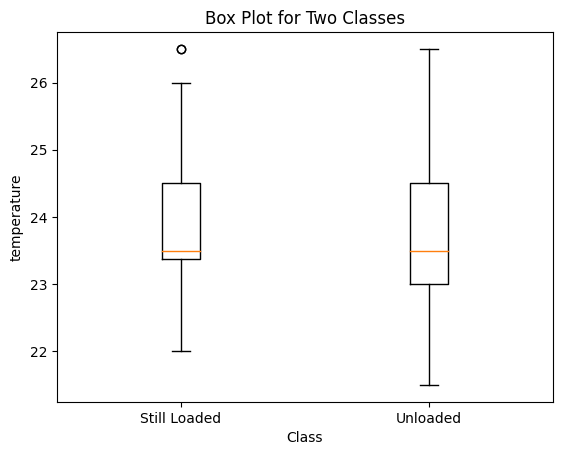

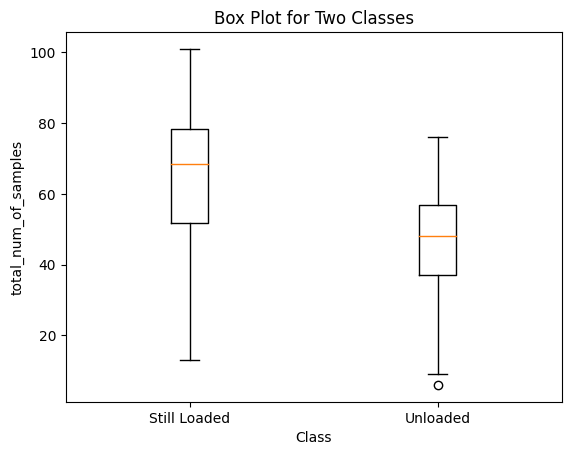

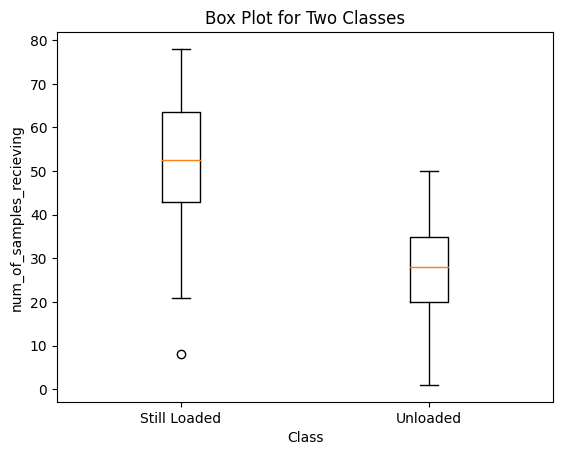

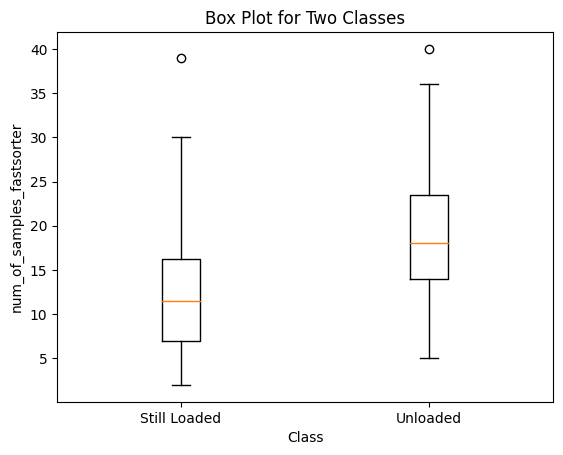

In [70]:
# Data exploration still loaded and unloaded

still_loaded_df = train_df_by_tag.loc[train_df_by_tag[UNLOAD_PRED]== 0]
unloaded_df = train_df_by_tag.loc[train_df_by_tag[UNLOAD_PRED]== 1]

plot_boxplot(df1=still_loaded_df, df2=unloaded_df, column_name=TEMPERATURE, labels=['Still Loaded', 'Unloaded'])
plot_boxplot(df1=still_loaded_df, df2=unloaded_df, column_name=TOTAL_NUM_OF_SAMPLES, labels=['Still Loaded', 'Unloaded'])
plot_boxplot(df1=still_loaded_df, df2=unloaded_df, column_name=NUM_OF_SAMPLES_R, labels=['Still Loaded', 'Unloaded'])
plot_boxplot(df1=still_loaded_df, df2=unloaded_df, column_name=NUM_OF_SAMPLES_FS, labels=['Still Loaded', 'Unloaded'])



In [36]:
overview(train_df)
add_time_diffrences(train_df)
train_df.head()

num_of_rows_w_nans_time_unload = train_df["time_to_unload"].shape[0] - train_df["time_to_unload"].dropna().shape[0]
print(f"number of rows with nan: {num_of_rows_w_nans_time_unload}")
train_med, train_q1, train_q3 = calc_median_q1_q3(train_df["time_to_unload"].dropna())
print(f"train time to unload analysis: med(q1-q3) {train_med}({train_q1}-{train_q3})")

#overview_per_tag(train_df)

df_t = train_df.loc[(train_df[PIXEL_ID] == "T2214") & (train_df["test"]== "test_1")]
print(df_t.shape[0])
df_t_2 = train_df.loc[(train_df[PIXEL_ID] == "T2214") & (train_df["test"]== "test_2")]
print(df_t_2.shape[0])
df_2296 = train_df.loc[(train_df[PIXEL_ID] == "T2296")]
print(df_2296.shape[0])
for index, r in df_t.iterrows():
  #t = convert_to_human_time(r[TIMESTAMP], full=True)

  print(f"{convert_to_human_time(r[TIMESTAMP], full=True)} - {convert_to_human_time(r[UNLOAD_TIMESTAMP], full = True)} {r[ZONE_NAME]}")



number of rows: 8289
number of tags: 163
number of gateways: 2
number of bridges: 9
zones: ['FastSorter' 'GMReceiving']
number of rows with nan: 2607
columns with nans: ['unload_timestamp', 'time_to_unload']
number of tags with loaded line: 123
number of rows with nan: 2607
train time to unload analysis: med(q1-q3) 19807.0(-21376.0-365762.25)
50
9
37
2023-05-12 15:27:43 - 2023-05-12 15:34:41 FastSorter
2023-05-12 15:30:01 - 2023-05-12 15:34:41 FastSorter
2023-05-12 15:34:28 - 2023-05-12 15:34:41 FastSorter
2023-05-12 15:19:29 - 2023-05-12 15:34:41 FastSorter
2023-05-12 15:34:57 - 2023-05-12 15:34:41 FastSorter
2023-05-12 15:43:31 - 2023-05-12 15:34:41 FastSorter
2023-05-12 15:22:35 - 2023-05-12 15:34:41 GMReceiving
2023-05-12 15:23:08 - 2023-05-12 15:34:41 GMReceiving
2023-05-12 15:23:32 - 2023-05-12 15:34:41 GMReceiving
2023-05-12 15:23:52 - 2023-05-12 15:34:41 GMReceiving
2023-05-12 15:24:24 - 2023-05-12 15:34:41 GMReceiving
2023-05-12 15:24:39 - 2023-05-12 15:34:41 GMReceiving
2023-

## Data Pre-processing

In [ ]:
#Please do data cleaning and pre-processing here
#create as many cells as necessary

In [37]:
def remove_rows_unload_before_load(df):
  #keep only rows where unload_timestamp is after timestamp or unload_timestamp is Nan meaning unloaded
  df_filtered = df[(df[TIMESTAMP] <  df[UNLOAD_TIMESTAMP]) | (df[UNLOAD_TIMESTAMP].isnull())]
  return df_filtered

In [38]:
df_t_filtered = remove_rows_unload_before_load(df_t)
print(df_t_filtered.shape[0])
df_t_filtered_2 = remove_rows_unload_before_load(df_t_2)
print(df_t_filtered_2.shape[0])
print(df_t_filtered_2[UNLOAD_TIMESTAMP])
print(df_t_2[UNLOAD_TIMESTAMP])

print(df_2296[UNLOAD_TIMESTAMP])
print(df_2296.shape[0])
df_2296_filtered =remove_rows_unload_before_load(df_2296)
print(df_2296_filtered[UNLOAD_TIMESTAMP])
print(df_2296_filtered.shape[0])

31
1
4780    1.683909e+12
Name: unload_timestamp, dtype: float64
4780    1.683909e+12
4781    1.683909e+12
4782    1.683909e+12
4783    1.683909e+12
4784    1.683909e+12
4785    1.683909e+12
4786    1.683909e+12
4787    1.683909e+12
4788    1.683909e+12
Name: unload_timestamp, dtype: float64
2703   NaN
2704   NaN
2705   NaN
2706   NaN
2707   NaN
2708   NaN
2709   NaN
2710   NaN
2711   NaN
2712   NaN
2713   NaN
2714   NaN
2715   NaN
2716   NaN
2717   NaN
2718   NaN
2719   NaN
2720   NaN
2721   NaN
2722   NaN
6291   NaN
6292   NaN
6293   NaN
6294   NaN
6295   NaN
6296   NaN
6297   NaN
6298   NaN
6299   NaN
6300   NaN
6301   NaN
6302   NaN
6303   NaN
6304   NaN
6305   NaN
6306   NaN
6307   NaN
Name: unload_timestamp, dtype: float64
37
2703   NaN
2704   NaN
2705   NaN
2706   NaN
2707   NaN
2708   NaN
2709   NaN
2710   NaN
2711   NaN
2712   NaN
2713   NaN
2714   NaN
2715   NaN
2716   NaN
2717   NaN
2718   NaN
2719   NaN
2720   NaN
2721   NaN
2722   NaN
6291   NaN
6292   NaN
6293   NaN
6294 

## Feature Engineering

In [ ]:
#If you plan on engineering features, please do so in this section.
#create as many cells as necessary

## Model & Heuristic Creation

In [ ]:
#Please use this area for any models or heuristics you create.
#create as many cells as necessary

In [ ]:
#sample required final output:
preds = 'sample_preds_unload.csv'
pred_df = pd.read_csv(preds)
pred_df

## Evaluation

This section will be used to evaluate your model on the hidden test set.

All cells are clearly marked if they should or should not be altered.

In [ ]:
#DO NOT ALTER - LOAD THE DATA FOR TEST PREDICTION

#import final test set
test = '../ds_interview_unload_test.csv'
test_df = pd.read_csv(test)

In [ ]:
#MODIFY THIS CELL

#Data Cleaning, Pre-processing, and Feature Engineering
#Please drop in any code/functions needed to process the test set into the correct format for inference.

In [ ]:
#MODIFY THIS CELL

#Run model / apply heuristics
#Please drop in any code needed to apply your algorithms to the test set.
#If you are using a model with weights, ensure this is sent in your final submission and the weight imports are done here.

In [ ]:
# MODIFY THIS CELL

#Format final predictions
#They should exist as a dataframe containing 3 columns: "pixel_id", "unload_pred", "unload_timestamp_pred".
#dataframe should be named "final_pred_df"


In [ ]:
#DO NOT ALTER - USE THIS TO TEST IF YOUR PREDICTION CONTAINS REQUIRED COLUMNS

import unittest
class TestPredResult(unittest.TestCase):
    def setUp(self, target_df):
        self.expected = ["pixel_id", "unload_pred", "unload_timestamp_pred"]
        self.result = list(target_df.columns)
    def test_count_eq(self):
        self.assertCountEqual(self.result, self.expected)

check_columns = TestPredResult()
check_columns.setUp(final_pred_df)
check_columns.test_count_eq()

In [ ]:
#DO NOT ALTER - EVALUATION FUNCTIONS

from sklearn.metrics import (
  f1_score,
  precision_score,
  recall_score,
  accuracy_score)
from sklearn import metrics
import seaborn as sns

def metric_eval(y_true, y_pred):

  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average="weighted")
  recall = recall_score(y_true, y_pred, average="weighted")
  f1 = f1_score(y_true, y_pred, average="weighted")
  print(f"Accuracy: {accuracy} \nPrecision: {precision} \nRecall: {recall} \nF1 score: {f1}")

  confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
  cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix, display_labels = [False, True])
  # cm_display.ax_.set_title("Confusion Matrix (cutoff = 0.5)")
  return accuracy, precision, recall, f1, cm_display

def compare_pred_true(
  compare_result_df: pd.DataFrame,
  true_label_colname: str = 'unload',
  true_time_colname: str = "unload_timestamp",
  pred_label_colname: str = 'unload_pred',
  pred_time_colname: str = "unload_timestamp_pred",
):

  compare_df = compare_result_df.copy()
  # confusion matrix
  accuracy, _, _, _, cm_display = metric_eval(
    compare_df[true_label_colname] , compare_df[pred_label_colname]
  )

  # time error
  compare_df["error_minute"] = (
    compare_df[pred_time_colname] - compare_df[true_time_colname]
  )/ 1000 / 60
  compare_df['error_minute_abs'] = np.abs(compare_df["error_minute"])

  extreme_error = compare_df[compare_df["error_minute_abs"] > 20].copy()
  correct_pred = compare_df[compare_df[true_label_colname] == compare_df[pred_label_colname]].copy()
  neg_pred = compare_df[compare_df.error_minute < -1].copy()


  print(
    f"""
    out of {len(compare_df)} cases,
    {len(correct_pred)} ({accuracy * 100:.2f}%) predicted correctly
    {len(neg_pred)} ({len(neg_pred)/len(compare_df) * 100:.2f}%) determined unload before actual time
    {len(extreme_error)} ({len(extreme_error)/len(compare_df) * 100:.2f}%) with extreme error larger than +/-10 minutes
    """
  )

  # plot side by side
  fig, ax = plt.subplots(1, 2, figsize = (10, 4))
  cm_display.plot(ax = ax[0])
  ax[0].set_title("Confusion Matrix")

  sns.histplot(compare_df["error_minute"], stat = "probability", ax = ax[1])
  ax[1].set_title("Time Error in Minutes")
  ax[1].set_ylim(0, 1.2)
  ax[1].set_xlim(-20, 20)

  return compare_df

In [ ]:
#DO NOT ALTER - APPLY THE EVALUATION FUNCTIONS ON TOP OF PREDICITON
# load true result
truth = '../ds_interview_unload_results.csv'
truth_df = pd.read_csv(truth)

# join with the prediction result and evaluate
compare_df = truth_df.merge(final_pred_df, how='left', on = ['pixel_id'])
compare_result = compare_pred_true(compare_result_df = compare_df)